In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def approxe_cube_splains(func, N, bounds, border_cond=(0, 0)):
    x = np.linspace(bounds[0], bounds[1], N)
    print(len(x))
    A = np.zeros((4*N, 4*N))
    b = np.array([*map(func, x)])
    
    for i in range(N):
        for j in range(N):
            if i == j:
                A[i][j * 4] = 1
                A[i][j * 4 + 1] = x[i]
                A[i][j * 4 + 2] = x[i] * x[i]
                A[i][j * 4 + 3] = x[i] * x[i] * x[i]

    # c = np.linalg.solve(A, b)
    print(A.shape, b.shape)
    print(A)
    # print(c)


def approxe_cube_splains2(func, N, bounds, border_cond=(0, 0)):
    x = np.linspace(bounds[0], bounds[1], N)
    A = []
    line = [0] * (4 * N)
    start_line = line.copy()
    start_line[0] = 1
    start_line[1] = x[0]
    start_line[2] = x[0] * x[0]
    start_line[3] = x[0] * x[0] * x[0]

    A.append(start_line)

    end_line = line.copy()
    end_line[-1] = x[-1] * x[-1] * x[-1]
    end_line[-2] = x[-1] * x[-1]
    end_line[-3] = x[-1]
    end_line[-4] = 1


    A.append()
    print(line)
    print(A)
    # A.append()

In [6]:
def main(func, N, bounds):
    """
    bounds: [min, max]
    """
    LEFT, RIGHT = 0.5, 1.5
    N = 10
    approxe_cube_splains2(lambda x: x + 1, 3, (LEFT, RIGHT))    
# end def

main(None, None, None)

TypeError: list.append() takes exactly one argument (0 given)

In [7]:
import numpy as np
from scipy.linalg import solve_banded

class CubicSpline:
    def __init__(self, x, y, bc_type='not-a-knot', extrapolate=None):
        self.x = np.asarray(x, dtype=float)
        self.y = np.asarray(y, dtype=float)
        self.bc_type = bc_type
        self.extrapolate = extrapolate

        if len(self.x) != len(self.y):
            raise ValueError("x и y должны иметь одинаковую длину.")
        if len(self.x) < 2:
            raise ValueError("Недостаточно точек для построения сплайна.")

        self._compute_coefficients()

    def _compute_coefficients(self):
        n = len(self.x) - 1
        h = np.diff(self.x)
        delta = np.diff(self.y) / h

        # Создаем ленточную матрицу A в формате, подходящем для solve_banded
        # A имеет 3 диагонали: нижнюю, главную и верхнюю
        A = np.zeros((3, n + 1))
        b = np.zeros(n + 1)

        # Заполняем главную диагональ
        A[1, 1:-1] = 2 * (h[:-1] + h[1:])
        # Заполняем нижнюю диагональ
        A[2, :-2] = h[:-1]
        # Заполняем верхнюю диагональ
        A[0, 2:] = h[1:]

        # Заполняем вектор b
        b[1:-1] = 3 * (delta[1:] - delta[:-1])

        # Граничные условия
        if self.bc_type == 'not-a-knot':
            A[1, 0] = h[1]
            A[0, 1] = -(h[0] + h[1])
            A[1, 1] = h[0]
            b[0] = 0

            A[1, -1] = h[-1]
            A[2, -2] = -(h[-2] + h[-1])
            A[1, -2] = h[-2]
            b[-1] = 0
        elif isinstance(self.bc_type, tuple) and self.bc_type[0] == 'clamped':
            df_a, df_b = self.bc_type[1]
            A[1, 0] = 2 * h[0]
            A[0, 1] = h[0]
            b[0] = 3 * (delta[0] - df_a)

            A[1, -1] = 2 * h[-1]
            A[2, -2] = h[-1]
            b[-1] = 3 * (df_b - delta[-1])
        else:
            raise ValueError("Неподдерживаемый тип граничных условий.")

        # Решаем систему
        c = solve_banded((1, 1), A, b)

        # Вычисляем коэффициенты сплайна
        self.a = self.y[:-1]
        self.b = delta - h * (2 * c[:-1] + c[1:]) / 3
        self.c = c[:-1]
        self.d = (c[1:] - c[:-1]) / (3 * h)

    def __call__(self, x):
        x = np.asarray(x, dtype=float)
        if not self.extrapolate and (np.any(x < self.x[0]) or np.any(x > self.x[-1])):
            raise ValueError("Точка x находится за пределами интервала интерполяции.")

        idx = np.searchsorted(self.x, x) - 1
        idx = np.clip(idx, 0, len(self.x) - 2)

        dx = x - self.x[idx]
        return self.a[idx] + self.b[idx] * dx + self.c[idx] * dx**2 + self.d[idx] * dx**3


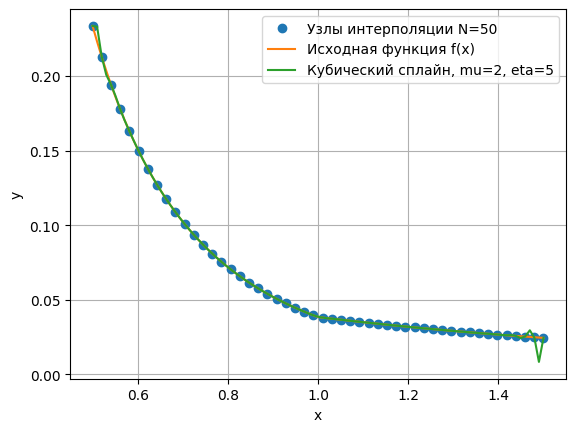

In [34]:
import numpy as np
# from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Определяем функцию f(x)
def f(x):
    return (1 + np.abs(np.log(x))) / (1 + 25 * x * x)

# Определяем отрезок [a, b]
a = 0.5
b = 1.5
N = 50
# Генерируем узлы интерполяции
x = np.linspace(a, b, N)
y = f(x)

# Вычисляем производные на концах отрезка
def deriv(f, x):
    h = 0.01
    return (f(x + h) - f(x - h)) / (2*h)
df_a = 2  # Производная функции f в точке a
df_b = 5   # Производная функции f в точке b

# Создаем кубический сплайн с жесткой заделкой концов
# cs = CubicSpline(x, y, bc_type=((1, df_a), (1, df_b)))
cs = CubicSpline(x, y, bc_type=('clamped', (df_a, df_b)))
# Генерируем точки для построения графика
x_new = np.linspace(a, b, 100)
y_new = cs(x_new)

# Строим графики
plt.plot(x, y, 'o', label='Узлы интерполяции N={}'.format(N))
plt.plot(x_new, f(x_new), label='Исходная функция f(x)')
plt.plot(x_new, y_new, label='Кубический сплайн, mu={}, eta={}'.format(np.round(df_a, 3), np.round(df_b, 3)))
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()


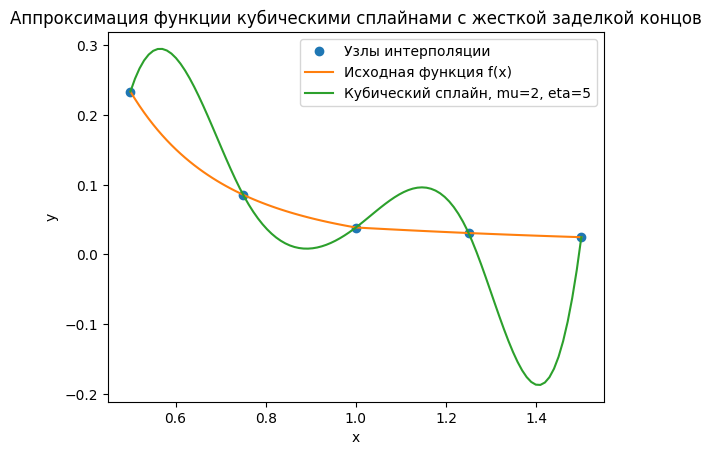

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Определяем функцию f(x)
def f(x):
    return (1 + np.abs(np.log(x))) / (1 + 25 * x * x)

# Определяем отрезок [a, b]
a = 0.5
b = 1.5

# Генерируем узлы интерполяции
x = np.linspace(a, b, 5)
y = f(x)

# Вычисляем производные на концах отрезка
def deriv(f, x):
    h = 0.01
    return (f(x + h) - f(x - h)) / (2 * h)

df_a = 2  # Производная функции f в точке a
df_b = 5  # Производная функции f в точке b

# Создаем кубический сплайн с жесткой заделкой концов
cs = CubicSpline(x, y, bc_type=('clamped', (df_a, df_b)))

# Генерируем точки для построения графика
x_new = np.linspace(a, b, 100)
y_new = cs(x_new)

# Строим графики
plt.plot(x, y, 'o', label='Узлы интерполяции')
plt.plot(x_new, f(x_new), label='Исходная функция f(x)')
plt.plot(x_new, y_new, label='Кубический сплайн, mu={}, eta={}'.format(np.round(df_a, 3), np.round(df_b, 3)))
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Аппроксимация функции кубическими сплайнами с жесткой заделкой концов')
plt.show()
